# Inorganic Material Generation using Deep Q-Networks
https://github.com/eltonpan/InorganicMaterialRL

Elton Pan

In [1]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep, generate_random_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy, predict_bulk_mod, predict_shear_mod, predict_band_gap
import json
from configs import configs
from utils.metrics import similarity_to_nearest_neighbor
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(torch.cuda.is_available())

/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


True


# Random policy
In env.py, we have generated some data using a random policy. Here, we visualize the distribution of final rewards, and then trained an agent using purely data generated by the random policy.

In [2]:
# Load Q_data_random
# with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
with open('./data/oxides_form_e-3/Q_data_random.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

def generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    en_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for episode in Q_c_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target, en_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])
            en_target = torch.tensor([en_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)
            en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)
    en_targets = torch.stack(en_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('en_targets:', en_targets.shape)
print('')

Number of episodes generated by random policy: 1000
s_material_inputs: torch.Size([5000, 145])
s_step_inputs: torch.Size([5000, 5])
a_elem_inputs: torch.Size([5000, 78])
a_comp_inputs: torch.Size([5000, 10])
Q_targets: torch.Size([5000, 1])
en_targets: torch.Size([5000, 1])



/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


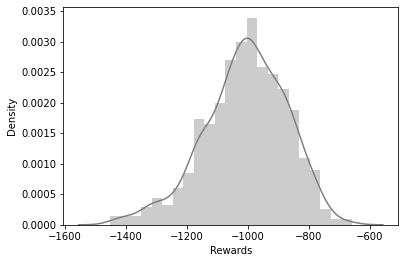

/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


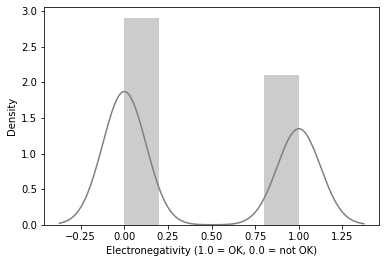

In [3]:
# Plot distribution of final rewards by random policy
plt.figure()
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random, color= 'grey')
plt.xlabel('Rewards')
plt.show()

# Plot distribution of en by random policy
plt.figure()
en_random = en_targets[0::5].reshape(-1) # find final rewards
sns.distplot(en_random, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

In [4]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

# # Save standard scaler
# joblib.dump(scaler, 'data/oxides_form_e-3/std_scaler.bin', compress=True)

# Load standard scaler
scaler = joblib.load('data/oxides_form_e-3/std_scaler.bin')

before scaling: tensor([[3.0000, 0.6481, 0.5749,  ..., 0.0000, 0.2135, 0.0508],
        [2.0000, 0.7115, 0.6376,  ..., 0.0000, 0.2135, 0.0527],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [2.0000, 0.7071, 0.6300,  ..., 0.0000, 0.0131, 0.0033],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 0.9195,  0.1490,  0.0441,  ..., -0.5586,  0.4265,  0.7670],
        [ 0.1639,  0.3296,  0.2241,  ..., -0.5586,  0.4265,  0.8198],
        [-0.5916,  1.1516,  1.2636,  ...,  1.7903, -0.6594, -0.6269],
        ...,
        [ 0.1639,  0.3172,  0.2021,  ..., -0.5586, -0.5926, -0.5367],
        [-0.5916,  1.1516,  1.2636,  ...,  1.7903, -0.6594, -0.6269],
        [-1.3471, -1.6974, -1.6050,  ..., -0.5586, -0.6594, -0.6269]])


In [5]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    en_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    en_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
    en_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]
    en_targets_train         = en_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]
    en_targets_valid         = en_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train,s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
                                    s_step_inputs = s_step_inputs.to('cuda'), 
                                    a_elem_inputs = a_elem_inputs.to('cuda'),
                                    a_comp_inputs = a_comp_inputs.to('cuda'),
                                    Q_targets  = Q_targets.to('cuda'),
                                    en_targets = en_targets.to('cuda'),
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([4000, 145])
s_step_inputs_train: torch.Size([4000, 5])
a_elem_inputs_train: torch.Size([4000, 78])
a_comp_inputs_train: torch.Size([4000, 10])
Q_targets_train: torch.Size([4000, 1])
en_targets_train: torch.Size([4000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([1000, 145])
s_step_inputs_valid: torch.Size([1000, 5])
a_elem_inputs_valid: torch.Size([1000, 78])
a_comp_inputs_valid: torch.Size([1000, 10])
Q_targets_valid: torch.Size([1000, 1])
en_targets_valid: torch.Size([1000, 1])


Here we train DQN using ONLY data generated by random policy.

# DQN

In [6]:
# Initialize Q network
dqn = DQN_pytorch().cuda()
print('CUDA for model: ', next(dqn.parameters()).is_cuda)

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.cpu().data.numpy(), 'Valid_loss = %.4f' % valid_loss.cpu().data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

CUDA for model:  True
Epoch =  0 Train_loss = 824.9969 Valid_loss = 824.6812
Epoch =  1 Train_loss = 823.8156 Valid_loss = 822.5399
Epoch =  2 Train_loss = 821.6759 Valid_loss = 818.9475
Epoch =  3 Train_loss = 818.0889 Valid_loss = 813.5095
Epoch =  4 Train_loss = 812.6608 Valid_loss = 805.8089
Epoch =  5 Train_loss = 804.9766 Valid_loss = 795.3896
Epoch =  6 Train_loss = 794.5869 Valid_loss = 781.7678
Epoch =  7 Train_loss = 780.9940 Valid_loss = 764.3901
Epoch =  8 Train_loss = 763.6580 Valid_loss = 742.6818
Epoch =  9 Train_loss = 741.9916 Valid_loss = 715.9726
Epoch =  10 Train_loss = 715.3434 Valid_loss = 683.5317
Epoch =  11 Train_loss = 682.9905 Valid_loss = 644.6456
Epoch =  12 Train_loss = 644.1968 Valid_loss = 598.4665
Epoch =  13 Train_loss = 598.1279 Valid_loss = 544.3475
Epoch =  14 Train_loss = 544.3141 Valid_loss = 489.8283
Epoch =  15 Train_loss = 490.7338 Valid_loss = 457.2213
Epoch =  16 Train_loss = 456.3475 Valid_loss = 427.8127
Epoch =  17 Train_loss = 427.0638 Va

# DCN

In [7]:
# Initialize constraint network
dcn = DCN_pytorch().cuda()

def train_DCN(dcn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid , Q_targets_valid, en_targets_valid):
    '''
    Trains DCN and prints: 1. training loss 2. validation loss

    Args:
    dcn: DCN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    en_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid
    en_targets_valid

    Returns:
    Updated dcn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dcn.parameters(), lr=1e-2)
    # loss_func = torch.nn.SmoothL1Loss().float()
    loss_func = torch.nn.MSELoss().float() # Works better than L1Loss
    # loss_func = torch.nn.L1Loss().float() # Trained model gives pred close to 0

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dcn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), en_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dcn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), en_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.cpu().numpy(), 'Valid_loss = %.4f' % valid_loss.data.cpu().numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dcn, train_loss_list, valid_loss_list
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

Epoch =  0 Train_loss = 0.2465 Valid_loss = 0.2483
Epoch =  1 Train_loss = 0.2663 Valid_loss = 0.2303
Epoch =  2 Train_loss = 0.2377 Valid_loss = 0.2362
Epoch =  3 Train_loss = 0.2391 Valid_loss = 0.2358
Epoch =  4 Train_loss = 0.2384 Valid_loss = 0.2313
Epoch =  5 Train_loss = 0.2352 Valid_loss = 0.2262
Epoch =  6 Train_loss = 0.2319 Valid_loss = 0.2231
Epoch =  7 Train_loss = 0.2307 Valid_loss = 0.2219
Epoch =  8 Train_loss = 0.2301 Valid_loss = 0.2219
Epoch =  9 Train_loss = 0.2286 Valid_loss = 0.2222
Epoch =  10 Train_loss = 0.2267 Valid_loss = 0.2219
Epoch =  11 Train_loss = 0.2249 Valid_loss = 0.2219
Epoch =  12 Train_loss = 0.2238 Valid_loss = 0.2211
Epoch =  13 Train_loss = 0.2218 Valid_loss = 0.2198
Epoch =  14 Train_loss = 0.2192 Valid_loss = 0.2177
Epoch =  15 Train_loss = 0.2167 Valid_loss = 0.2158
Epoch =  16 Train_loss = 0.2142 Valid_loss = 0.2153
Epoch =  17 Train_loss = 0.2110 Valid_loss = 0.2167
Epoch =  18 Train_loss = 0.2078 Valid_loss = 0.2169
Epoch =  19 Train_loss

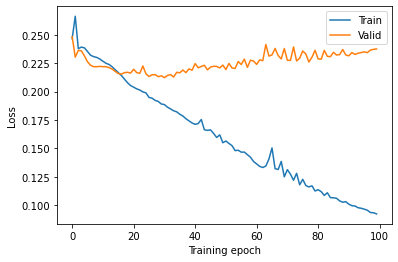

In [8]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [9]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set), oxide = False):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction
    oxide: Choose oxygen only 

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    0th index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    if oxide: # If oxygen only, we only need smaller action space
        n_actions = len(comp_set) - 1 # since adding 0 oxygen is NOT an option
    s_material_input = torch.stack([s_material]*n_actions).to('cuda')
    s_step_input = torch.stack([s_step]*n_actions).to('cuda')

    a_elem_input = []
    a_comp_input = []

    if oxide: # Consider oxygen only
        a_elem = torch.tensor(element_to_one_hot(['O'])[0]).float()
        # for comp in comp_set:
        for comp in comp_set[1:]: # consider only non-zero compositions for adding oxygen
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)

    else:
        for elem in element_set:
            a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
            for comp in comp_set:
                a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

                a_elem_input.append(a_elem)
                a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float().to('cuda')
    a_comp_input = torch.stack(a_comp_input).float().to('cuda')

    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.cpu().detach().numpy()
    Q_pred = Q_pred.reshape(n_actions)
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([n_actions, len(element_set)])
    a_comp_input_ranked = torch.zeros([n_actions, len(comp_set)])
    Q_pred_ranked = np.zeros(n_actions)

    for rank in reversed(range(n_actions)): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (n_actions - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Material: {}'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn, oxide = True)
print('Q value of max action: ', Q_pred_ranked[0])
print(len(Q_pred_ranked))
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
# print('')
print('')

print('Material: {}'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn, oxide = True)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Material: BaTiO3
Q value of max action:  -858.0064086914062
9

Material: SrTiO3
Q value of max action:  -839.5905151367188


In [10]:
# Investigate weights of dqn
# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0120, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0790, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0154, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0376, device='cuda:0', grad_fn=<MeanBackward0>))

In [11]:
# For testing the DCN function
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float().to('cuda')
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0]).to('cuda')
# print(s_step.shape)

a_elem = torch.zeros(78)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0]).to('cuda')
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0]).to('cuda')
# print(a_comp.shape)

output = dcn(s_material, s_step, a_elem, a_comp)

print(output)
# print(output.shape)

tensor([[0.9955]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [12]:
tasks = configs['tasks']
env = ConstrainedMaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,
                          tasks = tasks)

def generate_max_act(state, dqn, stochastic_top_frac = 0, oxide = False):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set),
                                                                    oxide = oxide)
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_constrained_max_act(state, dqn, dcn, en_threshold, stochastic_top_frac = 0, oxide = False):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set),
                                                                    oxide = oxide)
    
    tot_num_actions = len(a_elem_input_ranked)
    en = 0

    count = 0
    while en <= en_threshold: # Keep iterating until predicted en goes above 0.5
        if stochastic_top_frac != 0: # if stochastic
            act_idx = stochastic_top_frac*tot_num_actions # cut-off index
            rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
        else: # deterministic
            rank = 0 # take top action (index 0)
        max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
        max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max

        # print('state:', state)
        s_material, s_step = state # need to featurize/encode s_material and s_step
        # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
        s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
        s_material_inputs = torch.tensor(scaler.transform(s_material)).float().to('cuda')  # Standardize s_material
        s_step_inputs = torch.tensor(step_to_one_hot([s_step])[0]).reshape(1, -1).float().to('cuda') # Get one-hot rep of s_step
        max_a_elem = max_a_elem.reshape(1, -1).to('cuda')
        max_a_comp = max_a_comp.reshape(1, -1).to('cuda')
        # print('state:', state)
        # print('s_material_inputs:', s_material_inputs)
        # print('s_step_inputs:', s_step_inputs)
        # print('max_a_elem:', max_a_elem)
        # print('max_a_comp:', max_a_comp)
        en = dcn(s_material = s_material_inputs, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                        a_elem      = max_a_elem,     # torch.Size([batch_size,80])
                        a_comp      = max_a_comp,  # torch.Size([batch_size,10])
                        )  # Update en with prediction using DCN
        # print('en pred:', en[0])
        count += 1
        if count >= 100: # Tried more than 100 times
            print('Could not satisfy en constraint after %.0f actions' % count)
            break
    max_a_elem = max_a_elem[0]
    max_a_comp = max_a_comp[0]
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn_dcn(dqn, dcn, en_threshold, max_steps = 5, epsilon = 0, stochastic_top_frac = 0, oxide = False):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    dcn: Constraint-network for constraint value prediction
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest.
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):

        if np.random.uniform(0,1) > epsilon:
            if i == max_steps-1: # If last step, choose oxygen only
                action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                oxide = oxide)
                # action = generate_random_act(oxide = oxide)
            else:
                action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                oxide = False)
        else:
            if i == max_steps-1: # If last step, choose oxygen only
                action = generate_random_act(oxide = oxide)
            else:
                action = generate_random_act(oxide = False)
        # print(action)
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
ep, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, stochastic_top_frac = 0.15, en_threshold = 0., 
                                                oxide = True)

# compounds = []
# for i in tqdm(range(100)):
#     _, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, en_threshold = 0.0, stochastic_top_frac = 0.20)
#     compounds.append(final_compound)

# print(final_compound)
# print(check_electronegativity(final_compound))
# len(compounds)
final_compound

'Li4Se7O4'

In [13]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_c_datapoints_and_evaluate_policy(dqn, dcn, num_eps, epsilon, en_threshold = 0.4, stochastic_top_frac = 0.20, oxide = False):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. Default 0.4
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns:
    Q_c_data_trained: List of Q datapoints for training
    en_targets_trained: List of en datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, epsilon = epsilon, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                        oxide = oxide)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_c_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_c_data = extract_data_from_ep(episode)
        Q_c_data_trained.append(Q_c_data)

    # end = time.time()
    # print('time taken:', end - start)

    # Save Q_data
    # with open('./data/Q_data_trained_RF.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained_RF.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []
    en_targets_trained         = []

    for episode in Q_c_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target, en_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)
            en_target = torch.tensor([en_target])
            en_targets_trained.append(en_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    en_targets_trained = torch.stack(en_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5
    final_en_trained = en_targets_trained[0::5].reshape(-1)

    return Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds

# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
# generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 50, epsilon = 0, en_threshold = 0.4, 
#                                         stochastic_top_frac = 0.15,
#                                         oxide = True)
# print(len(Q_c_data_trained))
# print(len(en_targets_trained))
# print(len(final_rewards_trained))
# print(final_compounds)

In [14]:
# count = 0
# for target in en_targets_trained[::5]:
#     if target[0] == 1.:
#         count += 1
# print(count)

As shown in the plot below, an agent trained based on just data generated by a random policy can improve the distribution of rewards.

In [15]:
# # Plot distribution of final rewards by random vs trained policy
# plt.figure(figsize=(10,7))
# sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
# sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
# plt.ylabel('Probability density')
# plt.xlabel('Reward')
# # plt.ylim(0,0.0025)
# plt.xlim(-2000,0)
# plt.legend()
# # plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
# plt.show()

In [16]:
# # Plot distribution of en by random policy
# sns.distplot(en_targets_trained, color= 'grey')
# plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
# plt.show()

# Deep Reinforcement Learning
We now close the RL loop by training the agent on data generated by increasingly greedy policies. 

In [17]:
# replay_buffer = collections.deque(maxlen = 50000)
# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, 
#                                                                                                                            dcn = dcn,
#                                                                                                     num_eps = 100, 
#                                                                                                     epsilon = 0, 
#                                                                                                     en_threshold = 0.4,
#                                                                                                     stochastic_top_frac = 0.2)
# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target, en_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
        Q_c_datapoint = [s_material, s_step, a_elem, a_comp, Q_target, en_target]
        replay_buffer.extend([Q_c_datapoint])
    
    return replay_buffer

# replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                             s_step_inputs = s_step_inputs, 
#                                                             a_elem_inputs = a_elem_inputs, 
#                                                             a_comp_inputs = a_comp_inputs, 
#                                                                 Q_targets = Q_targets,
#                                                                 en_targets = en_targets)
# print('Number of Q datapoints in replay buffer (5 per episode):', len(replay_buffer))

In [18]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    em_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for Q_c_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target, en_target = Q_c_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])
        en_target = torch.tensor([en_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)
        en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs).to('cuda')
    s_step_inputs = torch.stack(s_step_inputs).to('cuda')
    a_elem_inputs = torch.stack(a_elem_inputs).to('cuda')
    a_comp_inputs = torch.stack(a_comp_inputs).to('cuda')
    Q_targets = torch.stack(Q_targets).to('cuda')
    en_targets = torch.stack(en_targets).to('cuda')

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
    

### Training the DQN

In [19]:
# num_iter = 500 # No. of training iterations
# epsilon  = 0.99   # Initial epsilon

# en_threshold =  0 # Because we don't want to train DCN online
# # en_threshold_ub = 0.5 # upper bound for en_threshold
# # iteration = np.arange(num_iter)
# # en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub

# replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
# dqn_save_freq = 10 # Save DQN model every n iterations
# dqn = DQN_pytorch().cuda() # Initialize DQN
# # dcn = DCN_pytorch().cuda() # Initialize DCN
# env = ConstrainedMaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# # Meta-data to store
# final_rewards_vs_iter   = []
# en_vs_iter              = []
# compounds_vs_iter       = []
# train_loss_list_vs_iter = []
# valid_loss_list_vs_iter = []
# epsilon_vs_iter         = []

# for iteration in tqdm(range(num_iter)):
#     print('=========== TRAINING ITERATION %.0f ===========' % iteration)
# #     en_threshold = en_threshold_vs_iter[iteration]
#     print('Current epsilon = ', epsilon)
#     print('Current en threshold = ', en_threshold)
#     epsilon_vs_iter.append(epsilon)
#     # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
#     print('A) GENERATING DATAPOINTS')
#     Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
#         generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = epsilon, en_threshold = en_threshold,
#                                                                                                     stochastic_top_frac = 0.15,
#                                                                                                     oxide = True) # Generate episodes and score them
#     final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
#     en_vs_iter.append(en_targets_trained)
#     compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
#     print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
#     print('Compounds generated:', final_compounds)
#     s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained) # Processing to give inputs and targets for DQN
#     replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                                 s_step_inputs = s_step_inputs, 
#                                                                 a_elem_inputs = a_elem_inputs, 
#                                                                 a_comp_inputs = a_comp_inputs, 
#                                                                     Q_targets = Q_targets,
#                                                                    en_targets = en_targets)
#     # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
#     print('B) TRAINING Q-NETWORK and C-NETWORK')
#     s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
#     s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs.cpu())).float().to('cuda') # Standardize s_material_inputs
#     s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
#     = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
#                                         s_step_inputs = s_step_inputs, 
#                                         a_elem_inputs = a_elem_inputs,
#                                         a_comp_inputs = a_comp_inputs,
#                                         Q_targets = Q_targets,
#                                         en_targets = en_targets,
#                                         valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
#     dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
#     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
#     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
#     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    
# #     dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
# #     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
# #     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
# #     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)
# #     train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
# #     valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

#     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
#         torch.save(dqn, './dqn_models/oxides_form_e-3/dqn_test_%.0fiter_RF_constrained' % iteration)

# #     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DCN model every n iterations
# #         torch.save(dcn, './dcn_models/constrained_DQN_cuda/dcn_test_%.0fiter_RF_constrained' % iteration)

#     epsilon *= 0.99 # Decay epsilon

# with open('./training_data/oxides_form_e-3/final_rewards_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/en_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/compounds_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/train_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/valid_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/epsilon_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [20]:
# torch.save(dqn, './dqn_models/oxides_form_e-3/dqn_test_500iter_RF_constrained')

# Applying constraints: Train DCN on random data
After DQN has been trained, we now train a separate neural network (DCN) to serve as a mask on top of DQN actions. This biases the actions toward those that are likely to give valid compounds (eg. correct electronegativity). 

We do this instead of training the DCN within the RL as this method performs better (higher validity) and, more importantly, is much faster (approx. 5x less run time).

Number of episodes generated by random policy: 1000
before scaling: tensor([[3.0000, 0.6481, 0.5749,  ..., 0.0000, 0.2135, 0.0508],
        [2.0000, 0.7115, 0.6376,  ..., 0.0000, 0.2135, 0.0527],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [2.0000, 0.7071, 0.6300,  ..., 0.0000, 0.0131, 0.0033],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 0.9195,  0.1490,  0.0441,  ..., -0.5586,  0.4265,  0.7670],
        [ 0.1639,  0.3296,  0.2241,  ..., -0.5586,  0.4265,  0.8198],
        [-0.5916,  1.1516,  1.2636,  ...,  1.7903, -0.6594, -0.6269],
        ...,
        [ 0.1639,  0.3172,  0.2021,  ..., -0.5586, -0.5926, -0.5367],
        [-0.5916,  1.1516,  1.2636,  ...,  1.7903, -0.6594, -0.6269],
        [-1.3471, -1.6974, -1.6050,  ..., -0.5586, -0.6594, -0.6269]],
       device='cuda:0')
TRAIN SIZES:
s_material_inputs_train: torch.Size([4000, 145])

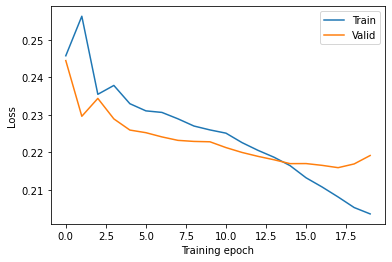

In [21]:
# Load Q_data_random
with open('./data/oxides_form_e-3/Q_data_random.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float().to('cuda')
print('after scaling:', s_material_inputs_scaled)

# Train-validation split
s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
                                    s_step_inputs = s_step_inputs.to('cuda'), 
                                    a_elem_inputs = a_elem_inputs.to('cuda'),
                                    a_comp_inputs = a_comp_inputs.to('cuda'),
                                    Q_targets  = Q_targets.to('cuda'),
                                    en_targets = en_targets.to('cuda'),
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

# Initialize constraint network
dcn = DCN_pytorch().cuda()

# Train DCN on random data
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 20, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [22]:
torch.save(dcn, './dcn_models/oxides_form_e-3/dcn_random_roost_constrained')

# Visualization of results

### Final reward of compounds generated from constrained model (DQN + DCN)

In [23]:
# Earlier models
# dqn = torch.load('./dqn_models/dqn_test_500iter_RF_constrained') # Trained in constrained RL
# dqn = torch.load('./dqn_models/dqn_test_490iter_RF') # Trained in unconstrained RL
# dcn = torch.load('./dcn_models/dcn_test_random_RF_constrained') # Trained on random data

# Final constrained models
dqn = torch.load('./dqn_models/oxides_form_e-3/dqn_490iter_roost_constrained') # Trained in constrained RL
dcn = torch.load('./dcn_models/oxides_form_e-3/dcn_random_roost_constrained') # Trained on random data

# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-1.8203e-05, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0217, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0124, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0291, device='cuda:0', grad_fn=<MeanBackward0>))

In [24]:
# 1. Get final rewards from random policy
with open('./data/oxides_form_e-3/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
en_random = en_targets[0::5].reshape(-1) # find final en

# 2. Get final rewards from trained policy
Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = 0.5, stochastic_top_frac = 0.20, oxide = True)

# Save compounds generated                                            
with open('./training_data/oxides_form_e-3/final_compounds_roost_constrained.pkl', 'wb') as f:
        pickle.dump(final_compounds, f, pickle.HIGHEST_PROTOCOL)

print(final_compounds)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


In [25]:
with open('./training_data/oxides_form_e-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

In [35]:
# check charge neutrality
len(check_neutrality_multiple(final_compounds)[0])/len(final_compounds)

0.819

/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost_EMD/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


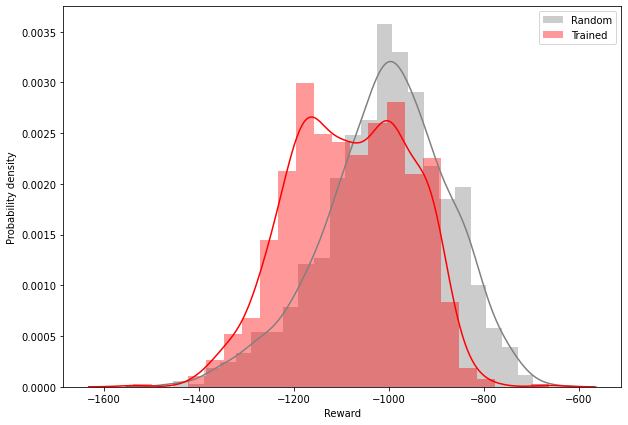

In [36]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained', color = 'red')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
# plt.xlim(-2000,0)   
plt.legend()
plt.savefig(fname = 'plots/oxides_form_e-3/reward_dist_500iter_roost_constrained.png', dpi = 300)
plt.show()

### Validity of compounds generated from constrained model (DQN + DCN)

In [27]:
# Validity of random
count_random = 0
for target in en_random:
    if target.item() == 1.:
        count_random += 1
print('Random policy: Fraction of en OK compounds = ' , count_random/len(en_random))
# Validity of trained
count_trained = 0
for target in en_targets_trained:
    if target.item() == 1.:
        count_trained += 1
print('Trained policy: Fraction of en OK compounds = ' , count_trained/len(en_targets_trained))
validity = {'random': count_random/len(en_random),
            'trained': count_trained/len(en_targets_trained)
            }
with open('training_data/oxides_form_e-3/validity.json', 'w') as f:
    json.dump(validity, f)

Random policy: Fraction of en OK compounds =  0.402
Trained policy: Fraction of en OK compounds =  0.694


### Experiment: Validity vs en_threshold

In [ ]:
# en_threshold_list  = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# en_good_ratio_vs_en_threshold = []

# def evaluate_en_threshold(en_threshold):
#     # 2. Get final rewards from trained policy
#     Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
#     generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = 0, 
#                                             en_threshold = en_threshold, stochastic_top_frac = 0.20, oxide = True)
#     # Validity of trained
#     count = 0
#     for target in en_targets_trained:
#         if target.item() == 1.:
#             count += 1
#     ratio = count/len(en_targets_trained)
#     return ratio

# for en_threshold in en_threshold_list:
#     en_good_ratio = evaluate_en_threshold(en_threshold = en_threshold)
#     en_good_ratio_vs_en_threshold.append(en_good_ratio)

# with open('./training_data/oxides_form_e-3/en_threshold_list_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_threshold_list, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_form_e-3/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_good_ratio_vs_en_threshold, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('./training_data/oxides_form_e-3/en_threshold_list_RF_constrained.pkl', 'rb') as f:
#     en_threshold_list = pickle.load(f)

# with open('./training_data/oxides_form_e-3/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'rb') as f:
#     en_good_ratio_vs_en_threshold = pickle.load(f)

# plt.figure(figsize=(10,7))
# plt.plot(en_threshold_list, en_good_ratio_vs_en_threshold)
# plt.ylabel('Fraction en OK')
# plt.xlabel('En threshold')
# # plt.savefig(fname = 'plots/oxides_form_e-3/en_good_ratio_vs_en_threshold_500iter_RF_constrained.png', dpi = 300)
# plt.show()

### Look at compounds

In [ ]:
# rf_regr = RandomForestRegressor()
# rf_regr = joblib.load("rf_models/optimal_sinter_RF.joblib")

# # Featurization for RF model
# feature_calculators = MultipleFeaturizer([
#     cf.element.Stoichiometry(),
#     cf.composite.ElementProperty.from_preset("magpie"),
#     cf.orbital.ValenceOrbital(props=["avg"]),
#     cf.ion.IonProperty(fast=True)
# ])

In [ ]:
# # Load compounds generated
# with open('./training_data/oxides_form_e-3/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)

# # For final compounds generated using constrained RL (DQN + DCN)
# good, bad = check_both_multiple(final_compounds)

In [ ]:
# print('Fraction of en OK compounds:', len(good)/(len(good) + len(bad)))

In [ ]:
# # Convert good ones to reduced formula
# for idx in range(len(good)):
#     good[idx] = Composition(good[idx]).reduced_formula

# # Predict sintering T of valid compounds
# max_len = 0
# good_sinter_T = []
# for compound in good:
#     chemical = Composition(compound)
#     features = feature_calculators.featurize(chemical) # No need to scale for RF model
#     features = np.array(features).reshape(1, -1)
#     # print(features)
#     sinter_T_pred = rf_regr.predict(features)[0]
#     good_sinter_T.append(sinter_T_pred)
#     compound = Composition(compound).reduced_formula
#     print('Compound:', compound, (18-len(compound)+3)*' ','Sinter T:', round(sinter_T_pred))

# plt.figure()
# sns.distplot(good_sinter_T)
# plt.xlabel('Sintering T')
# plt.show()

### Formation energy of generated compounds

In [ ]:
# # RANDOM POLICY
# # Load random oxides
# with open('./training_data/oxides_form_e-3/random_oxides.pkl', 'rb') as f: 
#     random_oxides = pickle.load(f)
# form_e_random = []
# for compound in random_oxides:
#     form_e_random.append(predict_formation_energy(compound))

# # Save predicted formation energies of random oxides                               
# with open('./training_data/oxides_form_e-3/form_e_random.pkl', 'wb') as f:
#         pickle.dump(form_e_random, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of random oxides 
with open('./training_data/oxides_form_e-3/form_e_random.pkl', 'rb') as f: 
    form_e_random = pickle.load(f)
    
stable_random = len([x for x in form_e_random if x <= 0])/len(form_e_random)
print(stable_random)

In [ ]:
# # UNCONSTRAINED DQN (sintering T only)
# with open('./training_data/oxides_form_e-3/compounds_vs_iter_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)
# final_compounds = final_compounds[-1]

form_e_unconstrained = []
for compound in final_compounds:
    form_e_unconstrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of UNconstrained DQN                                  
# with open('./training_data/oxides_form_e-3/form_e_500iter_RF.pkl', 'wb') as f:
#         pickle.dump(form_e_unconstrained, f, pickle.HIGHEST_PROTOCOL)

# # Load predicted formation energies of UNconstrained DQN
# with open('./training_data/oxides_form_e-3/form_e_500iter_RF.pkl', 'rb') as f: 
#     form_e_unconstrained = pickle.load(f)

# len([x for x in form_e_unconstrained if x <= 0])/len(form_e_unconstrained)

In [ ]:
# # CONSTRAINED DQN (sintering T + en constraint)
# # Load compounds generated
# with open('./training_data/oxides_form_e-3/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)

# form_e_constrained = []
# for compound in final_compounds:
#     form_e_constrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of constrained DQN                                  
# with open('./training_data/oxides_form_e-3/form_e_500iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(form_e_constrained, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of constrained DQN
with open('./training_data/oxides_form_e-3/form_e_500iter_RF_constrained.pkl', 'rb') as f: 
    form_e_constrained = pickle.load(f)

stable_trained = len([x for x in form_e_constrained if x <= 0])/len(form_e_constrained)
print(stable_trained)

In [ ]:
form_e_below_zero = {'random': stable_random,
                    'trained': stable_trained
            }
with open('training_data/oxides_form_e-3/form_e_below_zero.json', 'w') as f:
    json.dump(form_e_below_zero, f)

In [ ]:
plt.figure()
sns.distplot(form_e_random, bins = 30, hist = True, norm_hist = True, label = 'Random', color = 'grey')
# sns.distplot(form_e_unconstrained, hist = True, norm_hist = True, label = 'DQN', color = 'blue')
sns.distplot(form_e_constrained, hist = True, norm_hist = True, label = 'Constrained DQN', color = 'red')
plt.xlabel('Formation energy /eV')
plt.legend()
# plt.savefig('plots/oxides_form_e-3/form_e_comparison.png', dpi = 300)
plt.show()

In [ ]:
np.mean(form_e_constrained), np.std(form_e_constrained)

In [ ]:
similarity_to_nearest_neighbor(final_compounds)

# Visualizing training data of unconstrained DQN

### Evolution of final rewards with iteration (unconstrained DQN only)

In [ ]:
# with open('./training_data/final_rewards_vs_iter_RF_constrained.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)
# num_iter = 500
# final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
# final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
# plt.figure(figsize=(10,7))
# markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
# [bar.set_alpha(0.3) for bar in bars]
# [bar.set_color('orange') for bar in bars]
# plt.ylabel('Final reward')
# plt.xlabel('Training iteration')
# plt.legend()
# # plt.savefig(fname = 'plots/reward_vs_iter_500iter_RF_constrained.png', dpi = 300)
# plt.show()

### Evolution of compounds with iteration (unconstrained DQN only)

In [ ]:
# with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# # Load compound features
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'rb') as f:
#     compound_features_vs_iter = pickle.load(f)

In [ ]:
# len(compound_features_vs_iter)

Standarizing data before PCA is important.

In [ ]:
# # Load scalar
# scaler = StandardScaler() # Fit scaler
# scaler.fit(s_material_inputs)

# # Convert each compound features from list to np.array
# for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
#         compound_features_vs_iter[iteration][idx] = scaler.transform(np.array([compound_features_vs_iter[iteration][idx]]))[0] # Featurize using Magpie embeddings

In [ ]:
# features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
# for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
#     iteration_stack = []
#     for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
#         iteration_stack.append(compound_features_vs_iter[iteration][idx])
#     iteration_stack = np.stack(iteration_stack)
#     features.append(iteration_stack)

In [ ]:
# # Stack features into one big matrix
# full_stack = [] 
# for iteration in features:
#     full_stack.append(iteration)
# full_stack = np.vstack(full_stack)

### Dimensionality reduction using t-SNE

In [ ]:
# # Perform t-SNE
# tsne_embeddings = TSNE(n_components = 2, 
#                        perplexity = 30,
#                        learning_rate='auto',
#                        init='random' # random/pca initialization
#                        ).fit_transform(full_stack)

# # with open('training_data/tsne_embeddings_500iter_RF.npy', 'wb') as f:
# #     np.save(f, tsne_embeddings)

In [ ]:
# # Load t-SNE embeddings
# with open('training_data/tsne_embeddings_500iter_RF.npy', 'rb') as f:
#     tsne_embeddings = np.load(f)

# with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)

# final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
# final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
# print('tsne_embeddings: ', tsne_embeddings.shape)
# print('final_rewards:', final_rewards.shape)

In [ ]:
# # Generate list of iterations for 50k compounds
# iteration = []
# for i in range(500):
#     for j in range(100):
#         iteration.append(i)
# # Plot TSNE
# def plot_TSNE(train_iter = None):
#     fig = plt.figure(figsize=(6.5,5))
#     if train_iter == None:
#         plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = final_rewards, cmap = 'seismic') # For rewards
#         # plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = iteration, cmap = 'seismic') # For iteration
#     else:
#         row_idx = range(100*train_iter,(100*train_iter)+100)
#         rewards = final_rewards_vs_iter[train_iter]
#         plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
#     plt.ylabel('PC 2')
#     plt.xlabel('PC 1')
#     plt.ylim(-125, 125)
#     plt.xlim(-125, 125)
#     plt.legend()
#     # plt.text(20,100,'Iteration %.0f' % train_iter, fontsize = 15)
#     cbar = plt.colorbar()
#     cbar.set_label('Reward')
#     # cbar.set_label('Iteration')
#     plt.clim(-1000,-400) 
#     # plt.savefig(fname = 'plots/TSNE_vs_iter_500iter_RF.png', dpi = 300) 
#     plt.show()
#     return fig
# plot_TSNE()

In [ ]:
# images = []  # For saving into gif

# for i in range(0, 600, 1): # For stalling the last frame
#     j = i
#     if i > 499: # For stalling the last frame
#         j = 499
#     fig = plot_TSNE(train_iter = j)
#     # Used to return the plot as an image array 
#     # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     images.append(image)
# imageio.mimsave('plots/TSNE_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Dimensionality reduction using singular value decomposition (SVD)

In [ ]:
# # Perform SVD
# u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

# # with open('training_data/SVD_embeddings_500iter_RF.npy', 'wb') as f:
# #     np.save(f, u)

In [ ]:
# # Load SVD embeddings
# with open('training_data/SVD_embeddings_500iter_RF.npy', 'rb') as f:
#     u = np.load(f)

# with open('training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)

# final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
# final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
# print('SVD_embeddings: ', u.shape)
# print('final_rewards:', final_rewards.shape)

# u_truncated = u[:, :2]
# print('SVD_embeddings after truncation:', u_truncated.shape)

In [ ]:
# iteration = []
# for i in range(500):
#     for j in range(100):
#         iteration.append(i)

# # Plot SVD
# def plot_SVD(train_iter = None):
#     fig = plt.figure(figsize=(6.5,5))
#     if train_iter == None:
#         plt.scatter(u_truncated[:,0], u_truncated[:,1], c = final_rewards, s = 0.1, cmap = 'seismic') # For rewards
#         # plt.scatter(u_truncated[:,0], u_truncated[:,1], c = iteration, s = 0.1, cmap = 'seismic') # For iterations
#     else:
#         row_idx = range(100*train_iter,(100*train_iter)+100)
#         rewards = final_rewards_vs_iter[train_iter]
#         plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
#     plt.ylabel('PC 2')
#     plt.xlabel('PC 1')
#     plt.ylim(-0.013, 0.013)
#     plt.xlim(-0.009, .002)
#     plt.legend()
#     # plt.text(-0.002,0.010,'Iteration %.0f' % train_iter, fontsize = 15)
#     cbar = plt.colorbar()
#     plt.clim(-1000,-400)  
#     # cbar.set_label('Iteration')
#     cbar.set_label('Reward')
#     # plt.savefig(fname = 'plots/SVD_reward_vs_iter_500iter_RF.png', dpi = 300)
#     plt.show()
#     return fig
# plot_SVD()

In [ ]:
# images = []  # For saving into gif

# for i in range(0, 600, 1): # For stalling the last frame
#     j = i
#     if i > 499: # For stalling the last frame
#         j = 499
#     fig = plot_SVD(train_iter = j)
#     # Used to return the plot as an image array 
#     # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     images.append(image)
# imageio.mimsave('plots/SVD_reward_vs_iter_500iter_RF.gif', images, fps = 30)

# For NeurIPS workshop paper

In [ ]:
# # Load random oxides
with open('./training_data/random_oxides.pkl', 'rb') as f: 
    random_oxides = pickle.load(f)

# Load compounds
with open('./training_data/oxides_form_e-3/final_compounds_roost_constrained.pkl', 'rb') as handle:
    final_compounds = pickle.load(handle)

# Formation Energy
form_e_random = []
form_e_trained = []
for compound in random_oxides:
    form_e_random.append(predict_formation_energy(compound))
for compound in final_compounds:
    form_e_trained.append(predict_formation_energy(compound))

# Charge neutrality and electronegativity
cn_random_good, cn_random_bad = check_neutrality_multiple(random_oxides)
en_random_good, en_random_bad = check_electronegativity_multiple(random_oxides)
cn_trained_good, cn_trained_bad = check_neutrality_multiple(final_compounds)
en_trained_good, en_trained_bad = check_electronegativity_multiple(final_compounds)

# Uniqueness
random_oxides_unique = list(set(random_oxides))
final_compounds_unique = list(set(final_compounds))

results = {}
results['form_e_random_mean'] = np.mean(form_e_random)
results['form_e_random_std'] = np.std(form_e_random)
results['form_e_trained_mean'] = np.mean(form_e_trained)
results['form_e_trained_std'] = np.std(form_e_trained)
results['charge_neutral_random'] = len(cn_random_good)/(len(cn_random_good)+len(cn_random_bad))
results['electronegativity_balanced_random'] = len(en_random_good)/(len(en_random_good)+len(en_random_bad))
results['charge_neutral_trained'] = len(cn_trained_good)/(len(cn_trained_good)+len(cn_trained_bad))
results['electronegativity_balanced_trained'] = len(en_trained_good)/(len(en_trained_good)+len(en_trained_bad))
results['unique_random'] = len(random_oxides_unique)/len(random_oxides)
results['unique_trained'] = len(final_compounds_unique)/len(final_compounds)
results

In [ ]:
results

In [ ]:
print('Formation energy (random): {} ({})'.format(results['form_e_random_mean'], results['form_e_random_std']))
print('Formation energy (trained): {} ({})'.format(results['form_e_trained_mean'], results['form_e_trained_std']))